# Training a network against data from the Burgers equation

Training a Convolutional Neural Network (CNN) with data from the Burgers equation. See model_1d folder for the code that generated the data.

A simple setup for a surrogate model predicts the next time-step from the current one. This all starts from a mathematical model, which tyically involves Patial Differential Equations, but here we just collect the dynamic variables in the model in a vector $x$ at discrete times $t_0,t_1,\ldots,t_K$ and denote these as $x_k$. We can represent the numerical model as:

$x_{k+1}=M(x_k)$, starting with given initial condition $x_0$

Next, we run the numerical model and collect $x_0,x_1,\ldots,x_K$ as training data for our Machine Learning (ML) model. The aim of the ML model will be to approximate the numerical model, and we'll call it a surrogate model. It's main purpose is to have a faster but slightly less accurate version of the model. We denote the surrogate model as: 

$\hat{x}_{k+1}=\hat{M}(\hat{x}_k,\theta)$

starting with $\hat{x}_0=x_0$, which is the true initial condition.

This model has $\hat{x}_k$ as input and $x_{k+1}$ as output, and $\theta$ is a vector of parameters of the ML model to be estimated. For a given vector of parameters, one can sequentially compute $\hat{x}_1$, $\hat{x}_2$, $\hat{x}_3$, etc. This is called a rollout.

## Training

For training the most basic approach is to use one-step-ahead predictions. This means that the target is to accurately approximate the output of the numerical model. We can write this as a loss function:

$J(\theta) = \sum_{k=1}^{K-1} | x_{k+1} - \hat{M}(x_k,\theta)|^2$

Viewed as a supervised learning method, we have the generated data $x_k$ as inputs and $x_{k+1}$ as outputs. As is common in such cases the input data are collected in an input array $X$ and an output array $Y$ that consist of:

$X=[x_0,x_1,\ldots,x_{K-1}]$
$Y=[x_1,x_2,\ldots,x_{K}]$ 

We can generalize $\hat{M}$ to matrices to obtain:

$Y \approx \hat{M}(X,\theta)$

Unfortunately there is no guarantee that reasonably accurate one-step-ahead predictions lead to accurate rollouts, since the errors can accumulate quickly.


## Default experiment in this notebook

The example in this notebook uses a very (too) small dataset. This cannot lead to good results and doesn't allow for good independence of the validation dataset. 
Because the example uses a model with few weights it still seems to work reasonably and trains in a few seconds on cpu. 

In [1]:
# Initialize the Julia environment

# swithch to the directory where this script is located
cd(@__DIR__)
# Packages
using Pkg
Pkg.activate(".")

#Pkg.instantiate() # uncomment if you want to install the packages

# Load the required packages
using Flux
using BSON
using Plots, Measures
using JLD2
using ProgressMeter

# optional gpu usage
const use_gpu = false
if use_gpu
    using cuDNN, CUDA
    CUDA.allowscalar(false) # disable scalar operations on GPU
    if CUDA.functional() # check if CUDA is functional
        println("CUDA is functional, using GPU")
    else
        error("CUDA is not functional, using CPU")
    end
end

  Activating project at `~/dellete/src/julia_ml_tests.jl.git/training_1d_flux`


In [2]:
# Settings

# training
n_epochs = 1000
batch_size = 40
learning_rate = 0.005

# data
input_file = joinpath("..", "model_1d", "burgers1d_periodic.jld2")
n_train = 40 # number of training samples, set to 1000 for faster training
n_val = 10 # number of validation samples, set to 100 for faster training

# model
n_in = 1 # number of input channels (X)
n_out = 1 # number of output channels (Y)
n_hidden = 8 # number of hidden features in the model
n_filter= 3 # width of the convolutional filter

nothing

In [3]:
# Load the data and convert it to input and output arrays

# check if the input file exists
if !isfile(input_file)
    println("Data file not found: $input_file")
end
println("Loading data from $input_file")
data=load(input_file)

# sizes
n_times=length(data["solution"])
n_steps=n_times-1 # number of time steps in the data
n_points=length(data["solution"][1])

# Create inputs X and outputs Y
# Tensor shape: grid-points x channels x time-steps
X = zeros(Float32,n_points,1,n_times-1) # Float32 for GPU compatibility, 1 channel since only one variable u
Y = zeros(Float32,n_points,1,n_times-1) 
for t in 1:n_times-1 #copy data to the tensors
    X[:,:,t] .= data["solution"][t]
    Y[:,:,t] .= data["solution"][t+1]
end

@show size(X), X
@show size(Y), Y

# some metadata for plotting
output_times = data["times"][2:end]
output_x = data["grid"]
x0= X[:,:,1] # initial condition for rollout
nothing

Loading data from ../model_1d/burgers1d_periodic.jld2
(size(X), X) = ((100, 1, 50), Float32[1.4990133; 1.4960574; 1.4911436; 1.4842916; 1.4755282; 1.4648882; 1.4524136; 1.4381534; 1.422164; 1.4045085; 1.3852566; 1.3644843; 1.3422736; 1.318712; 1.2938926; 1.2679133; 1.2408768; 1.2128897; 1.1840622; 1.1545085; 1.124345; 1.0936906; 1.0626667; 1.0313953; 1.0; 0.96860474; 0.9373334; 0.90630937; 0.87565506; 0.8454915; 0.8159377; 0.7871103; 0.75912315; 0.7320866; 0.7061074; 0.681288; 0.65772647; 0.6355157; 0.61474335; 0.5954915; 0.57783604; 0.5618467; 0.5475865; 0.5351118; 0.52447176; 0.51570845; 0.50885636; 0.50394267; 0.50098664; 0.5; 0.50098664; 0.50394267; 0.50885636; 0.51570845; 0.52447176; 0.5351118; 0.5475865; 0.5618467; 0.57783604; 0.5954915; 0.61474335; 0.6355157; 0.65772647; 0.681288; 0.7061074; 0.7320866; 0.75912315; 0.7871103; 0.8159377; 0.8454915; 0.87565506; 0.90630937; 0.9373334; 0.96860474; 1.0; 1.0313953; 1.0626667; 1.0936906; 1.124345; 1.1545085; 1.1840622; 1.2128897; 1.2408

In [4]:
# Split the data into training and validation sets

# check if we have enough data to make a training and validation split
n_samples = size(X, 3)
if n_train + n_val > n_samples
    error("n_train + n_val must be less than or equal to the number of samples: $n_samples")
end

# Split the data into training and validation sets
X_train_cpu = X[:,:,1:n_train]
Y_train_cpu = Y[:,:,1:n_train]
X_val_cpu = X[:,:,n_train+1:n_train+n_val]
Y_val_cpu = Y[:,:,n_train+1:n_train+n_val]
@show size(X_train_cpu), size(Y_train_cpu)
@show size(X_val_cpu), size(Y_val_cpu)

(size(X_train_cpu), size(Y_train_cpu)) = ((100, 1, 40), (100, 1, 40))
(size(X_val_cpu), size(Y_val_cpu)) = ((100, 1, 10), (100, 1, 10))


((100, 1, 10), (100, 1, 10))

In [5]:
# move data to gpu or keep on cpu
if use_gpu
    X_train = gpu(X_train_cpu)
    Y_train = gpu(Y_train_cpu)
    X_val = gpu(X_val_cpu)
    Y_val = gpu(Y_val_cpu)
else
    X_train = X_train_cpu
    Y_train = Y_train_cpu
    X_val = X_val_cpu
    Y_val = Y_val_cpu
end

# create the data loaders
train_loader = Flux.DataLoader((X_train, Y_train), batchsize=min(batch_size,n_train), shuffle=true)

val_loader = Flux.DataLoader((X_val, Y_val), batchsize=min(batch_size,n_val), shuffle=false)

@show train_loader
@show val_loader
nothing

train_loader = DataLoader(::Tuple{Array{Float32, 3}, Array{Float32, 3}}, shuffle=true, batchsize=40)
val_loader = DataLoader(::Tuple{Array{Float32, 3}, Array{Float32, 3}}, batchsize=10)


In [6]:
# Create the model
n_pad=n_filter ÷ 2 # padding for the convolutional layer
PadCircular(x) = pad_circular(x, (n_pad,n_pad,0,0,0,0))

model_residual = Chain(
    PadCircular,
    Conv((n_filter,), n_in=>n_hidden, swish),
    PadCircular,
    Conv((n_filter,), n_hidden=>n_hidden, swish),
    PadCircular,
    Conv((n_filter,), n_hidden=>n_hidden, swish),
    PadCircular,
    Conv((n_filter,), n_hidden=>n_out)
)

# Define the model with residual block
struct ResidualBlock
    f::Chain
end

# Define how the ResidualBlock works
(m::ResidualBlock)(x) = x + m.f(x)

# Allow Flux to recognize ResidualBlock as a layer
Flux.@layer ResidualBlock

# create the model with residual blocks
model_cpu = ResidualBlock(model_residual)

# Show the model strucure and number of parameters
@show model_cpu

# Move model to gpu or keep on cpu
if use_gpu
    model = gpu(model_cpu)
else
    model = model_cpu
end

model_cpu = ResidualBlock(Chain(PadCircular, Conv((3,), 1 => 8, swish), PadCircular, Conv((3,), 8 => 8, swish), PadCircular, Conv((3,), 8 => 8, swish), PadCircular, Conv((3,), 8 => 1)))


ResidualBlock(
  Chain(
    Main.PadCircular,
    Conv((3,), 1 => 8, swish),          # 32 parameters
    Main.PadCircular,
    Conv((3,), 8 => 8, swish),          # 200 parameters
    Main.PadCircular,
    Conv((3,), 8 => 8, swish),          # 200 parameters
    Main.PadCircular,
    Conv((3,), 8 => 1),                 # 25 parameters
  ),
)                   # Total: 8 arrays, 457 parameters, 2.387 KiB.

In [7]:
# Train the model

# Initialize the ADAM optimizer with default settings
optimizer = Flux.setup(Adam(learning_rate),model)

# train loop
train_loss = Float32[]
val_loss = Float32[]
@showprogress for epoch in 1:n_epochs
    # Train the model on the training data
    # Loop over minibathches in the training data
    for (x_batch, y_batch) in train_loader
        loss, grads = Flux.withgradient(model) do m
            # Evaluate model and loss inside gradient context:
            y_hat = m(x_batch) # apply the model to the input batch
            Flux.mse(y_hat, y_batch) # compute the loss
        end
        Flux.update!(optimizer, model, grads[1])
    end
    # evaluate over all training data and validation data
    # NOTE: we careless with compute, rerunning model each time below
    Y_train_hat = model(X_train)
    train_loss_epoch = Flux.mse(Y_train_hat, Y_train)
    push!(train_loss, train_loss_epoch)
    Y_val_hat = model(X_val)
    val_loss_epoch = Flux.mse(Y_val_hat, Y_val)
    push!(val_loss, val_loss_epoch)
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


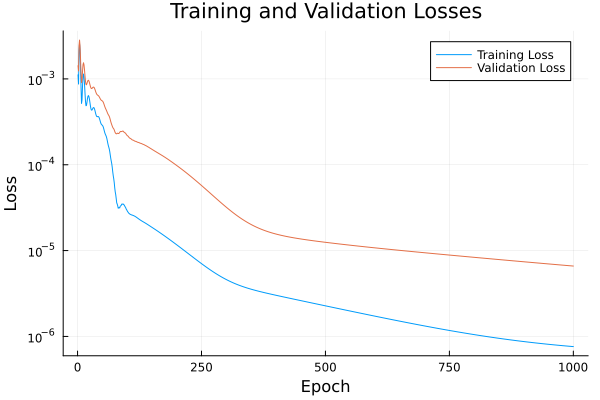

In [8]:
# Plot losses for training and validation
plot(train_loss, label="Training Loss", xlabel="Epoch", ylabel="Loss", title="Training and Validation Losses",yscale=:log10)
plot!(val_loss, label="Validation Loss", xlabel="Epoch",yscale=:log10)

In [9]:
# unroll the model to get the output for the initial condition
function unroll(model, x0, n_steps)
    x = reshape(x0, size(x0, 1), size(x0, 2), 1) # ensure x0 is 3
    outputs = zeros(Float32, size(x0, 1), size(x0, 2), n_steps+1)
    outputs[:,:,1] .= x0 # store the initial condition
    # unroll the model for nstep
    for t in 1:n_steps
        x = model(x)
        outputs[:,:,t+1] .= x
    end
    return outputs
end

# unroll the model to get the output for the initial condition
Y_unroll = unroll(model_cpu, x0, n_steps)

nothing

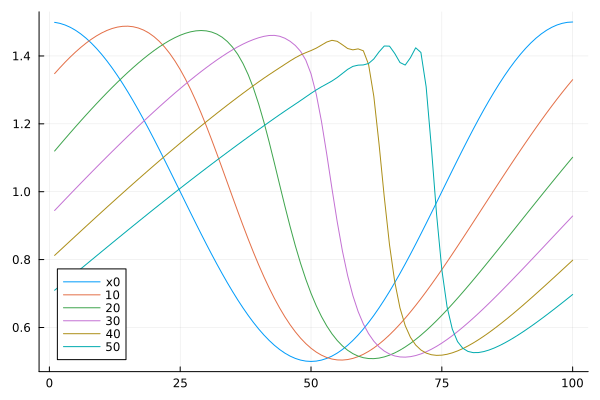

In [10]:
# plot some snapshots of the unrolled model output
plot(Y_unroll[:, 1, 1], label="x0")
plot!(Y_unroll[:,1,11], label="10")
plot!(Y_unroll[:,1,21], label="20")
plot!(Y_unroll[:,1,31], label="30")
plot!(Y_unroll[:,1,41], label="40")
plot!(Y_unroll[:,1,51], label="50")

┌ Info: Saved animation to /home/verlaan/dellete/src/julia_ml_tests.jl.git/training_1d_flux/burgers1d_periodic_ml_unroll.gif
└ @ Plots /home/verlaan/.julia/packages/Plots/gYkEG/src/animation.jl:156


  1.775512 seconds (2.80 M allocations: 144.720 MiB, 1.59% gc time, 36.94% compilation time: 5% of which was recompilation)


Plots.AnimatedGif("/home/verlaan/dellete/src/julia_ml_tests.jl.git/training_1d_flux/burgers1d_periodic_ml_unroll.gif")
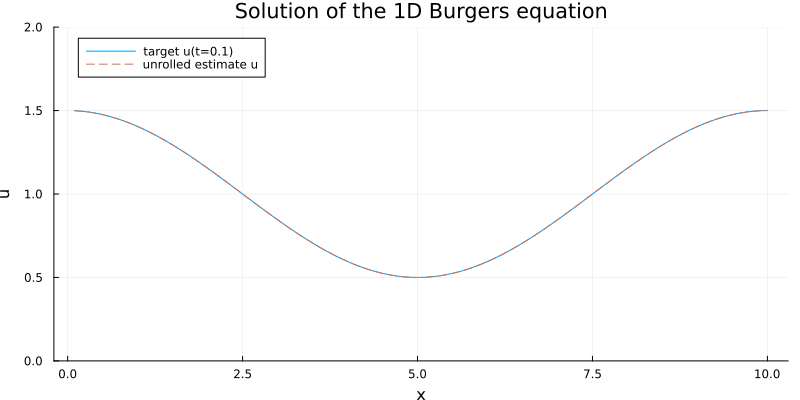

In [11]:
# Make movie of the unrolled output
@time begin
    # create a movie of the solution
    anim = @animate for i in 1:length(output_times)
        p1 = plot(output_x, X[:,1,i], label="target u(t=$(round(output_times[i],digits=2)))", xlabel="x", ylabel="u", ylim=(0, 2))
        plot!(output_x, Y_unroll[:,1,i], label="unrolled estimate u", linestyle=:dash)
        plot(p1, size=(800,400), title="Solution of the 1D Burgers equation")
    end
    gif(anim, "burgers1d_periodic_ml_unroll.gif", fps=15)
end